In [1]:
# Nhập xuất và thư viện thường dùng
import os
from pathlib import Path
import numpy as np
import pandas as pd

# Xử lí timeseries
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# Fill dữ liệu
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

# Đánh giá
from sklearn.metrics import make_scorer
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# Mô hình
import lightgbm as lgb
import optuna

# Tối ưu mô hình
from scipy.optimize import minimize

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

SEED = 42
root = Path('/kaggle/input/child-mind-institute-problematic-internet-use')

# Định nghĩa
KAPPA_SCORER = make_scorer(
    cohen_kappa_score, 
    greater_is_better = True, 
    weights = 'quadratic',
)

## Preprocessing

### Đọc dữ liệu

In [2]:
df_train = pd.read_csv(root/'train.csv')
df_test = pd.read_csv(root/'test.csv')
df_subm = pd.read_csv(root/'sample_submission.csv', index_col = 'id')

In [3]:
# Hàm hỗ trợ import timeseries
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis = 1, inplace = True)
    
    return df.describe().values.reshape(-1), filename.split('=')[1]

### Timeseries

In [4]:
# Timeseries
def load_time_series(dirname):
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total = len(ids)))
    
    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

In [5]:
ts_train = load_time_series(root/"series_train.parquet")
ts_test = load_time_series(root/"series_test.parquet")

100%|██████████| 2/2 [00:00<00:00,  9.31it/s]


In [6]:
df_train = pd.merge(df_train, ts_train, how = "left", on = 'id')
df_test = pd.merge(df_test, ts_test, how = "left", on = 'id')

df_train = df_train.set_index('id')
df_test = df_test.set_index('id')

time_series_cols = ts_train.columns.tolist()
time_series_cols.remove("id")

## EDA

In [7]:
target_labels = ['None', 'Mild', 'Moderate', 'Severe']

In [8]:
train_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')

print(f"Shape of train_df: {train_df.shape}")
print(train_df.info())

Shape of train_df: (3960, 82)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference  

In [9]:
train_df.columns

Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST'

In [10]:
# đếm record có sii
train_df_filtered = train_df[train_df['sii'].notna()]
train_df_filtered['sii'].count()

2736

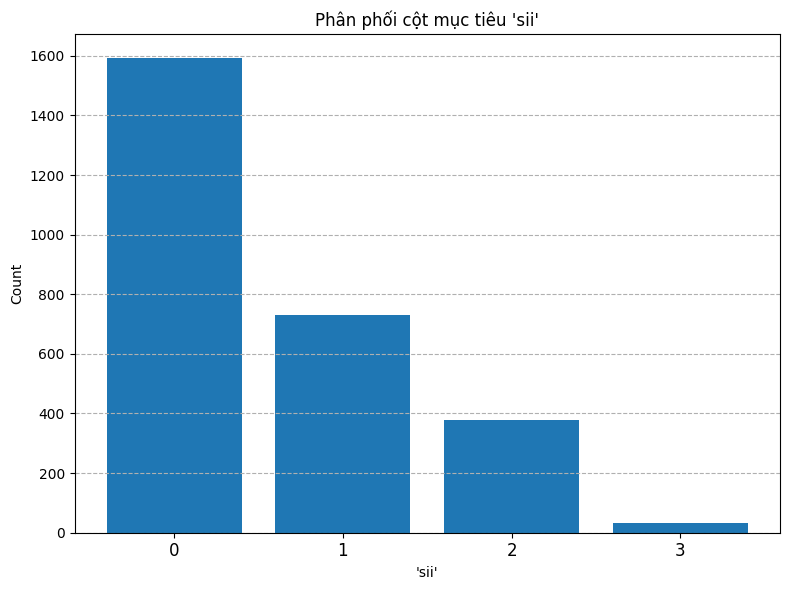

In [11]:
# Phân phối cột mục tiêu 'sii'
sii_counts = train_df_filtered['sii'].value_counts()

# Vẽ
plt.figure(figsize=(8, 6))
plt.bar(sii_counts.index, sii_counts.values)
plt.title("Phân phối cột mục tiêu 'sii'")
plt.xlabel("'sii'")
plt.ylabel("Count")
plt.xticks(ticks=sii_counts.index, labels=[int(i) for i in sii_counts.index], fontsize=12)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

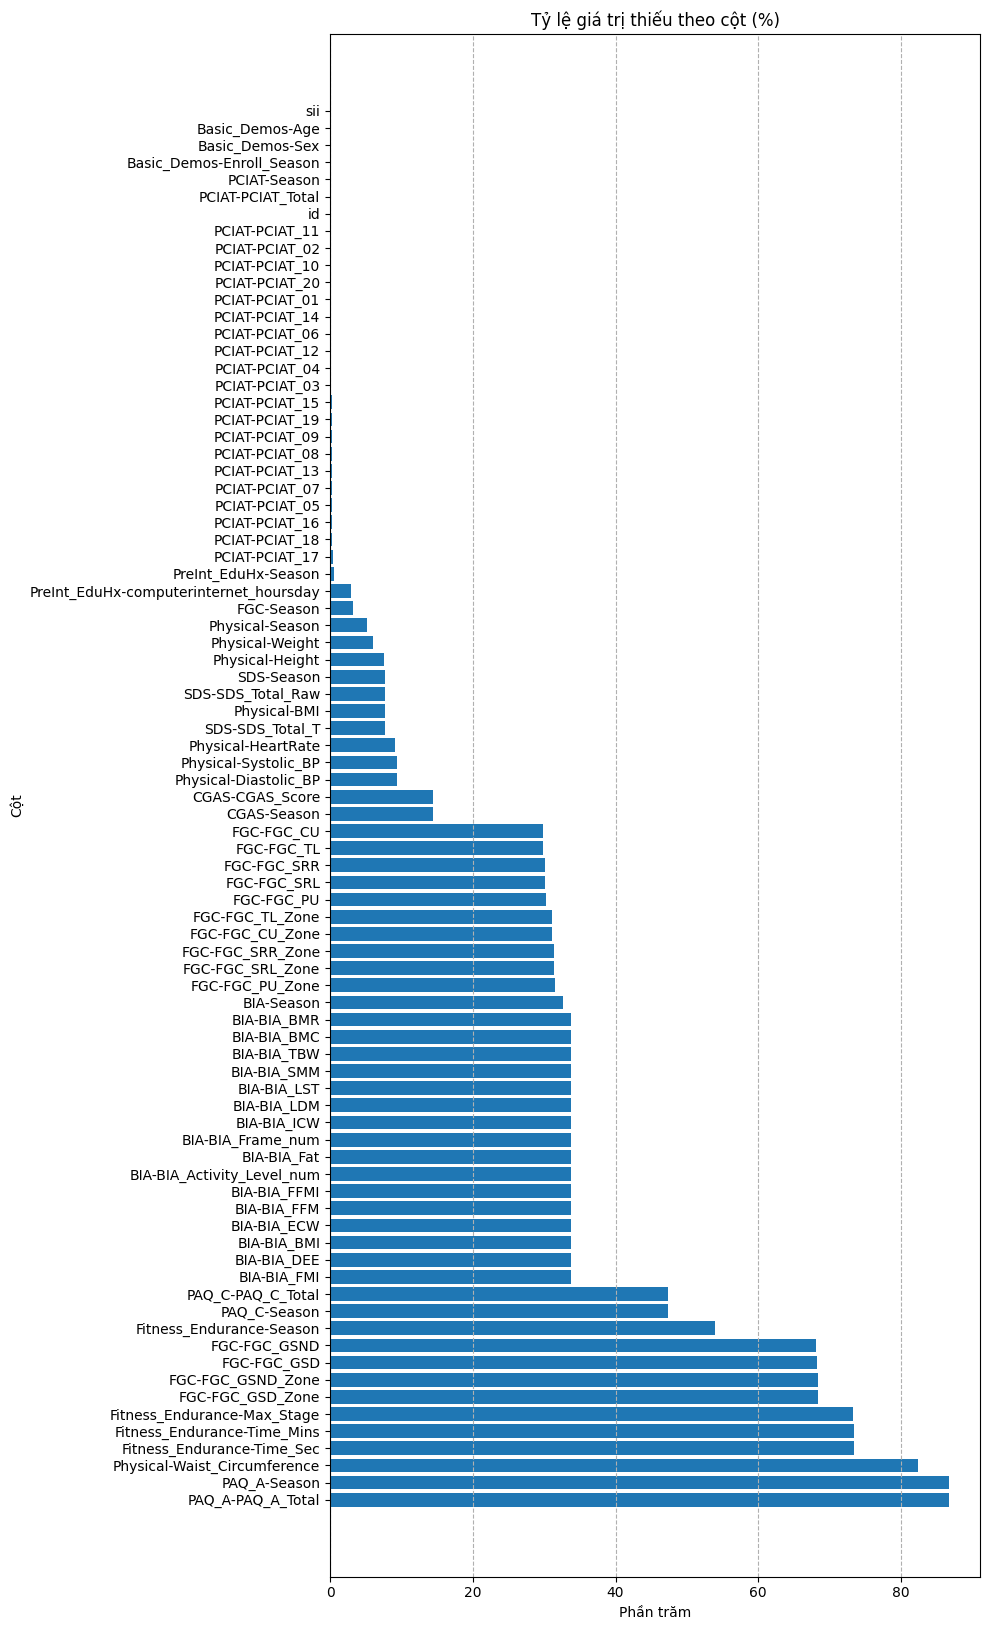

In [12]:
# Số giá trị thiếu các cột
missing_counts = train_df_filtered.isnull().sum()

# Tỷ lệ %
missing_ratio = (missing_counts / len(train_df_filtered)) * 100

# Sắp xếp các cột theo tỷ lệ giá trị thiếu
missing_ratio_sorted = missing_ratio.sort_values(ascending=False)

# Vẽ
plt.figure(figsize=(10, len(missing_ratio_sorted) * 0.2))
plt.barh(missing_ratio_sorted.index, missing_ratio_sorted.values)
plt.xlabel('Phần trăm')
plt.ylabel('Cột')
plt.title('Tỷ lệ giá trị thiếu theo cột (%)')
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()

In [13]:
columns_to_keep = missing_ratio[missing_ratio <= 50].index

train_df_cleaned = train_df_filtered[columns_to_keep]
print(f"Kích thước của train_df_cleaned: {train_df_cleaned.shape}")

train_df_cleaned.info()

Kích thước của train_df_cleaned: (2736, 71)
<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Data columns (total 71 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      2736 non-null   object 
 1   Basic_Demos-Enroll_Season               2736 non-null   object 
 2   Basic_Demos-Age                         2736 non-null   int64  
 3   Basic_Demos-Sex                         2736 non-null   int64  
 4   CGAS-Season                             2342 non-null   object 
 5   CGAS-CGAS_Score                         2342 non-null   float64
 6   Physical-Season                         2595 non-null   object 
 7   Physical-BMI                            2527 non-null   float64
 8   Physical-Height                         2530 non-null   float64
 9   Physical-Weight                         2572 non-null   float64
 10  Physical-Diastolic_BP

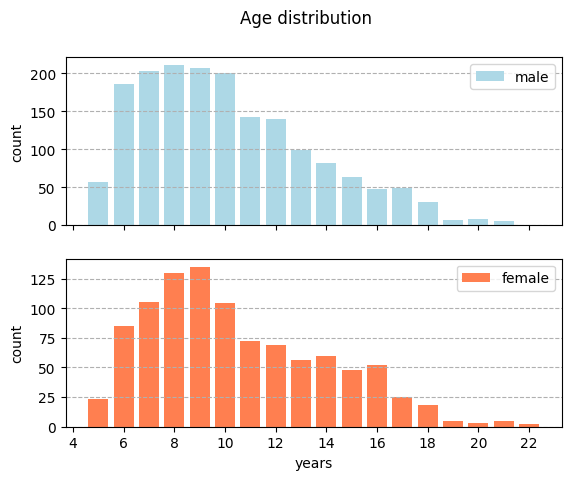

In [14]:
# Phân bố độ tuổi của nam và nữ tham gia khảo sát
colors = ['lightblue', 'coral']
labels = ['male', 'female']

_, axs = plt.subplots(2, 1, sharex=True)

for sex, color, label in zip(range(2), colors, labels):
    es = train_df_cleaned[train_df_cleaned['Basic_Demos-Sex'] == sex]['Basic_Demos-Age'].value_counts().sort_index()
    axs[sex].bar(es.index, es.values, color=color, label=label)
    axs[sex].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[sex].set_ylabel('count')
    axs[sex].legend()

for ax in axs:
    ax.grid(axis='y', linestyle='--')
axs[1].set_xlabel('years')
plt.suptitle('Age distribution')
plt.show()

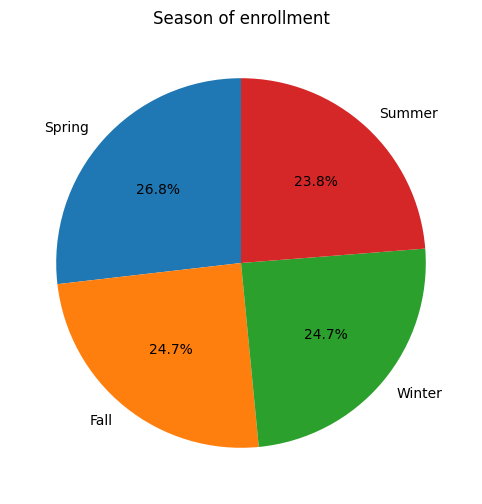

In [15]:
# Tính số lượng người tham gia của từng mùa
es = train_df_cleaned['Basic_Demos-Enroll_Season'].value_counts()

# Vẽ
plt.figure(figsize=(8, 6))
plt.pie(es.values, labels=es.index, autopct='%1.1f%%', startangle=90)
plt.title('Season of enrollment')
plt.show()

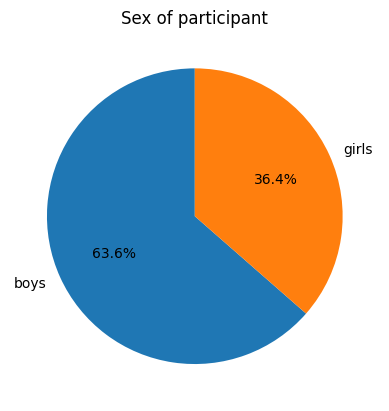

In [16]:
# Tỷ lệ nam, nữ
sex_mapping = {0: 'boys', 1: 'girls'}

es = train_df_cleaned['Basic_Demos-Sex'].value_counts()
es.index = es.index.map(sex_mapping)

plt.pie(es, labels=es.index, autopct='%1.1f%%', startangle=90)
plt.title('Sex of participant')
plt.show()

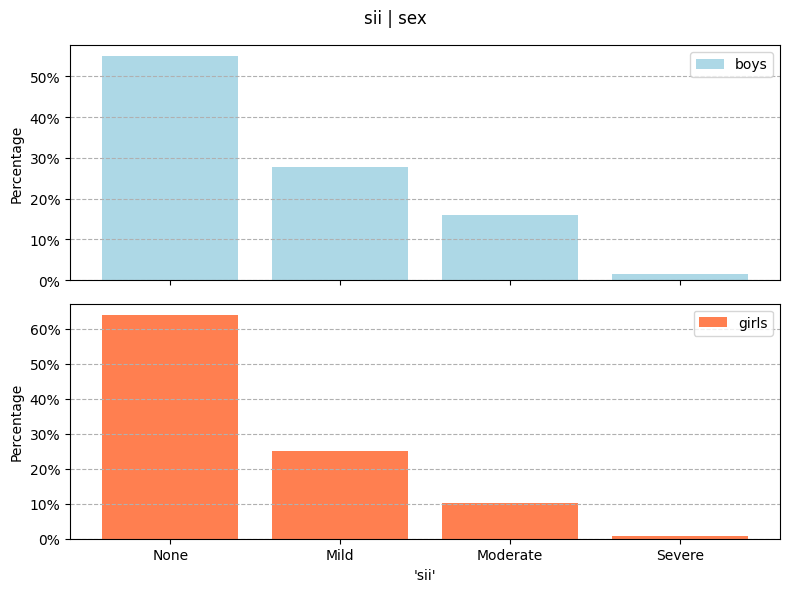

In [17]:
from matplotlib.ticker import PercentFormatter

colors = ['lightblue', 'coral']
labels = ['boys', 'girls']
x_labels = ['None', 'Mild', 'Moderate', 'Severe']

# Vẽ
_, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

for sex, ax, color, label in zip([0, 1], axs, colors, labels):
    es = train_df_cleaned[train_df_cleaned['Basic_Demos-Sex'] == sex]['sii'].value_counts(normalize=True).sort_index()
    ax.bar(es.index, es.values, color=color, label=label)
    ax.set_ylabel('Percentage')
    ax.legend()
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels)
    ax.grid(axis='y', linestyle='--')

axs[1].set_xlabel("'sii'")
plt.suptitle('sii | sex')
plt.tight_layout()
plt.show()

In [18]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5)

# Lấy các cột số
num_cols = train_df_cleaned.select_dtypes(include=['float64', 'int64']).columns

# Điền giá trị thiếu
train_df_cleaned.loc[:, num_cols] = knn_imputer.fit_transform(train_df_cleaned[num_cols])

train_df_cleaned.isnull().sum()

id                                          0
Basic_Demos-Enroll_Season                   0
Basic_Demos-Age                             0
Basic_Demos-Sex                             0
CGAS-Season                               394
                                         ... 
SDS-SDS_Total_Raw                           0
SDS-SDS_Total_T                             0
PreInt_EduHx-Season                        17
PreInt_EduHx-computerinternet_hoursday      0
sii                                         0
Length: 71, dtype: int64

In [19]:
from sklearn.impute import SimpleImputer

# Lấy danh sách các cột chứa dữ liệu kiểu object
cat_cols = train_df_cleaned.select_dtypes(include=['object']).columns

# Tạo bộ imputer để điền giá trị thiếu bằng giá trị xuất hiện nhiều nhất
cat_imputer = SimpleImputer(strategy='most_frequent')

# Sử dụng iloc để cập nhật các cột dữ liệu
cat_col_indices = [train_df_cleaned.columns.get_loc(col) for col in cat_cols]
train_df_cleaned.iloc[:, cat_col_indices] = cat_imputer.fit_transform(train_df_cleaned.iloc[:, cat_col_indices])

train_df_cleaned.isnull().sum()

id                                        0
Basic_Demos-Enroll_Season                 0
Basic_Demos-Age                           0
Basic_Demos-Sex                           0
CGAS-Season                               0
                                         ..
SDS-SDS_Total_Raw                         0
SDS-SDS_Total_T                           0
PreInt_EduHx-Season                       0
PreInt_EduHx-computerinternet_hoursday    0
sii                                       0
Length: 71, dtype: int64

In [20]:
train_df_cleaned = train_df_cleaned.copy()  # Tạo bản sao độc lập

season_mapping = {'Spring': 1, 'Summer': 2, 'Fall': 3, 'Winter': 4}
season_cols = [col for col in train_df_cleaned.columns if 'Season' in col]

for col in season_cols:
    train_df_cleaned.loc[:, col] = train_df_cleaned[col].map(season_mapping)

In [21]:
train_df_no_id = train_df_cleaned.drop(columns = ['id'], errors = 'ignore')

In [22]:
pciat_columns = [col for col in train_df_cleaned.columns if 'PCIAT-PCIAT' in col and col != 'PCIAT-PCIAT_Total']
corr_with_total = train_df_cleaned[pciat_columns].corrwith(train_df_cleaned['PCIAT-PCIAT_Total'])
print("Mối tương quan với PCIAT_PCIAT_TOTAL:")
print(corr_with_total)

train_df_no_id.drop(columns= pciat_columns, inplace=True)
train_df_cleaned.drop(columns= pciat_columns, inplace=True)

Mối tương quan với PCIAT_PCIAT_TOTAL:
PCIAT-PCIAT_01    0.728246
PCIAT-PCIAT_02    0.789033
PCIAT-PCIAT_03    0.823509
PCIAT-PCIAT_04    0.625314
PCIAT-PCIAT_05    0.831479
PCIAT-PCIAT_06    0.703399
PCIAT-PCIAT_07    0.492813
PCIAT-PCIAT_08    0.770630
PCIAT-PCIAT_09    0.721021
PCIAT-PCIAT_10    0.761529
PCIAT-PCIAT_11    0.684858
PCIAT-PCIAT_12    0.411792
PCIAT-PCIAT_13    0.772177
PCIAT-PCIAT_14    0.722164
PCIAT-PCIAT_15    0.824310
PCIAT-PCIAT_16    0.769773
PCIAT-PCIAT_17    0.824338
PCIAT-PCIAT_18    0.801978
PCIAT-PCIAT_19    0.737316
PCIAT-PCIAT_20    0.754248
dtype: float64


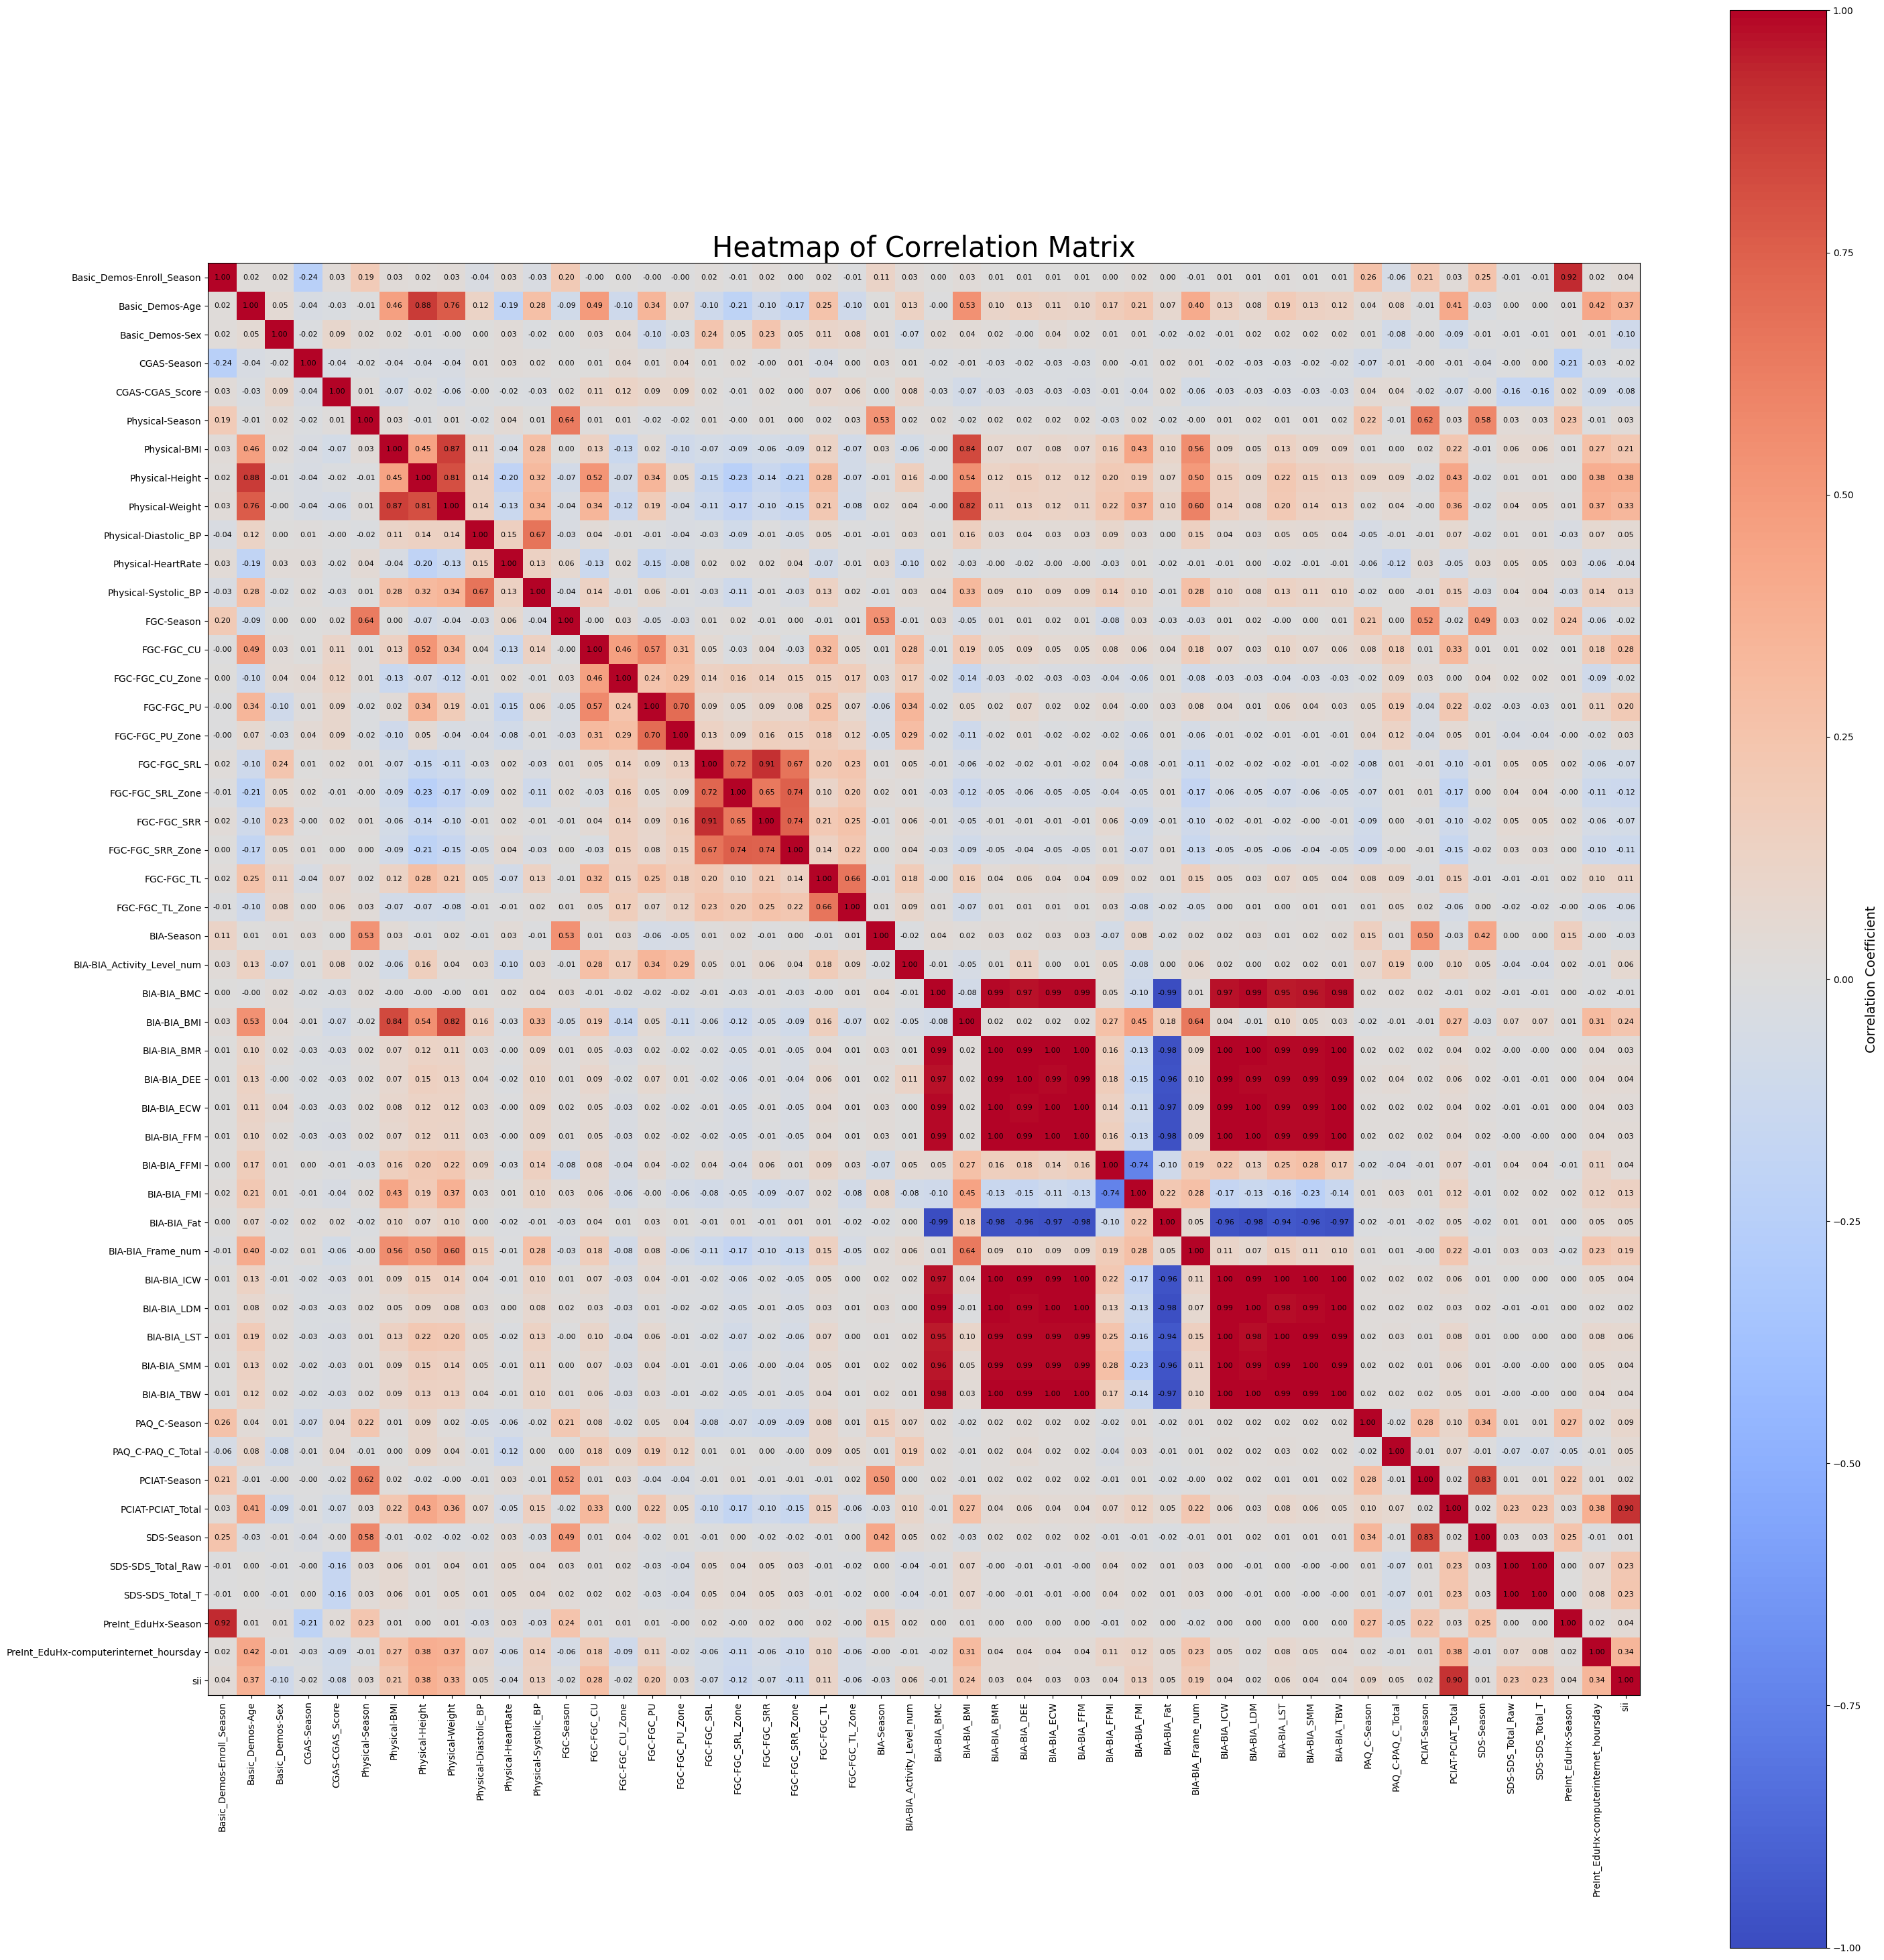

In [23]:
# Tính ma trận tương quan
corr_matrix = train_df_no_id.corr()

# Vẽ
plt.figure(figsize=(30, 30))

# Vẽ heatmap
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest', vmin=-1, vmax=1)

# Thêm thanh màu (colorbar)
cbar = plt.colorbar()
cbar.set_label('Correlation Coefficient', fontsize=14)

# Thêm nhãn 
plt.xticks(ticks=np.arange(len(corr_matrix.columns)), labels=corr_matrix.columns, rotation=90, fontsize=10)
plt.yticks(ticks=np.arange(len(corr_matrix.index)), labels=corr_matrix.index, fontsize=10)

# Thêm giá trị tương quan vào heatmap
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", 
                 ha='center', va='center', color='black', fontsize=8)

plt.title('Heatmap of Correlation Matrix', fontsize=30)
plt.tight_layout()
plt.show()

In [24]:
threshold = 0.8
to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            to_drop.add(colname)

to_drop.discard('sii')

train_df_cleaned = train_df_cleaned.drop(columns=to_drop)

print(f"Những cột đã bị loại bỏ: {to_drop}")
print(train_df_cleaned.shape)  

train_df_cleaned = train_df_cleaned.drop(columns=['PCIAT-Season', 'PCIAT-PCIAT_Total'])

Những cột đã bị loại bỏ: {'BIA-BIA_BMR', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_Fat', 'Physical-Height', 'BIA-BIA_ECW', 'BIA-BIA_LDM', 'PreInt_EduHx-Season', 'FGC-FGC_SRR', 'Physical-Weight', 'BIA-BIA_ICW', 'SDS-Season', 'SDS-SDS_Total_T', 'BIA-BIA_FFM', 'BIA-BIA_BMI', 'BIA-BIA_DEE', 'BIA-BIA_TBW'}
(2736, 34)


In [25]:
actigraphy = pd.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=00115b9f/part-0.parquet')
actigraphy

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0,0.021536,0.022214,-1.022370,0.022853,-88.280762,0.0,53.000000,4188.000000,56940000000000,4,3,41.0
1,1,0.022005,0.022187,-1.019740,0.020231,-88.241707,0.0,51.666668,4188.166504,56945000000000,4,3,41.0
2,2,0.022240,0.022005,-1.019401,0.019893,-88.170067,0.0,50.333332,4188.333496,56950000000000,4,3,41.0
3,3,0.021589,0.022578,-1.018177,0.018667,-88.250031,0.0,50.500000,4188.500000,56955000000000,4,3,41.0
4,4,0.022005,0.023763,-1.014323,0.016848,-88.130775,0.0,33.166668,4181.000000,57235000000000,4,3,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43325,43325,-0.008333,-0.023620,-1.006901,0.007224,-88.595741,0.0,0.000000,3824.000000,57580000000000,6,3,85.0
43326,43326,0.048730,-0.076725,-0.953776,0.056839,-85.352219,0.0,0.000000,3824.000000,57640000000000,6,3,85.0
43327,43327,0.387370,0.793151,-0.402214,0.069961,-24.097908,0.0,0.000000,3824.000000,57645000000000,6,3,85.0
43328,43328,0.801953,0.501589,-0.040937,0.045489,-2.113776,0.0,0.000000,3824.000000,57650000000000,6,3,85.0


In [26]:
from matplotlib.ticker import MaxNLocator

def analyze_actigraphy(id, train, only_one_week=False, small=False):
    actigraphy = pd.read_parquet(f'/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id={id}/part-0.parquet')
    
    # Tính ngày từ time_of_day (ns)
    time_in_days = actigraphy['relative_date_PCIAT'] + actigraphy['time_of_day'] / 62400e9
    
    # Lấy thông tin từ train
    sample = train[train['id'] == id]
    age = sample['Basic_Demos-Age'].iloc[0]
    sex = ['boy', 'girl'][sample['Basic_Demos-Sex'].iloc[0]]
    
    # Thêm các cột mới
    actigraphy['diff_seconds'] = time_in_days.diff() * 62400
    actigraphy['norm'] = np.sqrt(actigraphy['X']**2 + actigraphy['Y']**2 + actigraphy['Z']**2)
    
    # Xử lý bộ lọc thời gian nếu chỉ lấy trong 1 tuần
    if only_one_week:
        start = np.ceil(time_in_days.min())
        mask = (start <= time_in_days) & (time_in_days <= start + 21)
        mask &= ~actigraphy['non-wear_flag'].astype(bool)
    else:
        mask = np.full(len(time_in_days), True)
    
    # Đặc trưng cần hiển thị
    timelines = [('enmo', 'forestgreen'), ('light', 'orange')] if small else [
        ('X', 'm'), ('Y', 'm'), ('Z', 'm'),
        ('enmo', 'forestgreen'), ('anglez', 'lightblue'),
        ('light', 'orange'), ('non-wear_flag', 'chocolate')
    ]
    
    _, axs = plt.subplots(len(timelines), 1, sharex=True, figsize=(12, len(timelines) * 1.1 + 0.5))
    
    # Vẽ 
    for ax, (feature, color) in zip(axs, timelines):
        ax.set_facecolor('#eeeeee')
        ax.scatter(time_in_days[mask], actigraphy[feature][mask], color=color, label=feature, s=1)
        ax.legend(loc='upper left', facecolor='#eeeeee')
        if feature == 'diff_seconds':
            ax.set_ylim(-0.5, 20.5)
    
    axs[-1].set_xlabel('day')
    axs[-1].xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    axs[0].set_title(f'id={id}, {sex}, age={age}')
    plt.show()

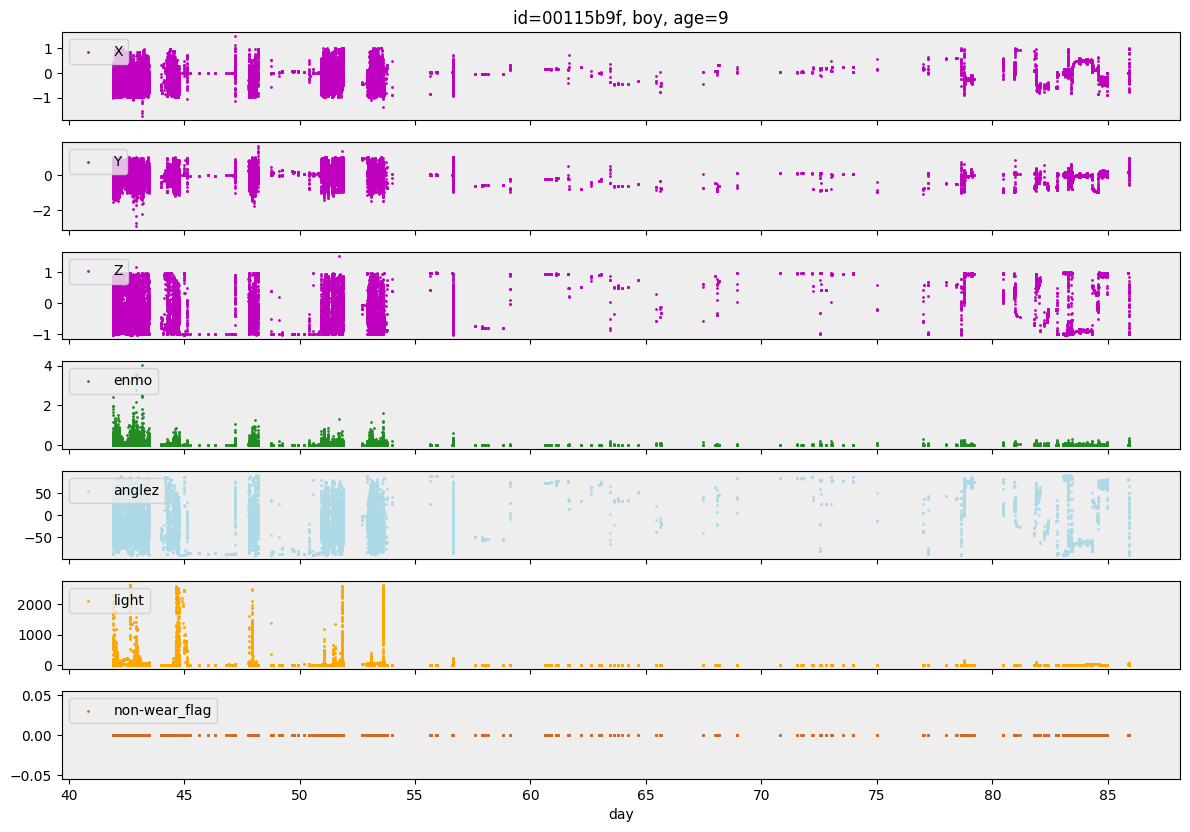

In [27]:
analyze_actigraphy('00115b9f', train_df)

### Phân loại và loại một số features

In [28]:
# Phân loại dữ liệu category, number,...
cat_cols = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']
num_cols = ['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday']
tabular_cols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season', 'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-Season', 'PreInt_EduHx-computerinternet_hoursday']
target_col = 'sii'

feature_cols = tabular_cols + time_series_cols
num_cols = num_cols + time_series_cols

# Bỏ các features thiếu nhiều
unused_features = ['stat_10', 'stat_11', 'stat_3', 'stat_4', 'stat_41', 'stat_42', 'stat_44', 'stat_5', 'stat_58', 'stat_6', 'stat_69', 'stat_7', 'stat_70', 'stat_77', 'stat_79', 'stat_8', 'stat_88', 'stat_89', 'stat_9', 'stat_93', 'stat_46', 'stat_56', 'stat_57', 'stat_64', 'stat_68', 'stat_92', 'stat_94', 'stat_27', 'stat_28', 'stat_39', 'stat_82', 'stat_2', 'stat_37', 'stat_43', 'stat_45', 'stat_53', 'stat_60', 'stat_1', 'stat_22', 'stat_72', 'stat_18', 'stat_91']

feature_cols = [f for f in feature_cols if f not in unused_features]
num_cols = [f for f in num_cols if f not in unused_features]
cat_cols = [f for f in cat_cols if f not in unused_features]

### Loại các record không có cột mục tiêu

In [29]:
df_train = df_train.dropna(subset = [target_col])

### Fill dữ liệu

#### Fill giá trị thiếu dạng number

In [30]:
imputer = SimpleImputer(
    strategy = 'mean',
)

df_train[num_cols] = imputer.fit_transform(df_train[num_cols])
df_test[num_cols] = imputer.transform(df_test[num_cols])

#### Fill giá trị thiếu dạng category

In [31]:
encoder = OrdinalEncoder(
    dtype = np.int32,
    handle_unknown = 'use_encoded_value',
    unknown_value = -1,
    encoded_missing_value = -2,
)

df_train[cat_cols] = encoder.fit_transform(df_train[cat_cols])
df_train[cat_cols] = df_train[cat_cols].astype('category')

df_test[cat_cols] = encoder.transform(df_test[cat_cols])
df_test[cat_cols] = df_test[cat_cols].astype('category')

## Xây dựng mô hình

### Sử dụng làm tròn cận và dự đoán score để tránh overfitting

In [32]:
def threshold_rounder(y_pred, thresholds):
    return np.where(y_pred < thresholds[0], 0,
                    np.where(y_pred < thresholds[1], 1,
                             np.where(y_pred < thresholds[2], 2, 3)))

def eval_preds(thresholds, y_true, y_pred):
    y_pred = threshold_rounder(y_pred, thresholds)
    score = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
    return -score

### Xây dựng mô hình custom từ LGBM, tự động hóa và tối ưu

In [33]:
class CustomLGBMRegressor(lgb.LGBMRegressor):
    def fit(self, X, y, **kwargs):
        super().fit(X, y, **kwargs)
        y_pred = super().predict(X, **kwargs)
        
        self.optimizer = minimize(
            eval_preds, 
            x0 = [0.5, 1.5, 2.5], 
            args = (y, y_pred), 
            method = 'Nelder-Mead',
        )
        
    def predict(self, X, **kwargs):
        y_pred = super().predict(X, **kwargs)
        y_pred = threshold_rounder(y_pred, self.optimizer.x)
        return y_pred

### Tìm tham số cho model

In [34]:
# Searcher
def lgb_objective(trial):
    params = {
        'objective':         'l2',
        'verbosity':         -1,
        'n_iter':            200,
        'random_state':      SEED,
        'boosting_type':     'gbdt',
        'lambda_l1':         trial.suggest_float('lambda_l1', 1e-3, 10.0, log=True),
        'lambda_l2':         trial.suggest_float('lambda_l2', 1e-3, 10.0, log=True),
        'learning_rate':     trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True),
        'max_depth':         trial.suggest_int('max_depth', 4, 8),
        'num_leaves':        trial.suggest_int('num_leaves', 16, 256),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'colsample_bynode':  trial.suggest_float('colsample_bynode', 0.4, 1.0),
        'bagging_fraction':  trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq':      trial.suggest_int('bagging_freq', 1, 7),
        'min_data_in_leaf':  trial.suggest_int('min_data_in_leaf', 5, 100),
    }
    
    X = df_train[feature_cols]
    y = df_train[target_col]
    cv = StratifiedKFold(5, shuffle = True, random_state = SEED)
    estimator = CustomLGBMRegressor(**params)

    val_scores = cross_val_score(
        estimator = estimator, 
        X = X,
        y = y, 
        cv = cv, 
        scoring = KAPPA_SCORER,
    )

    return np.mean(val_scores)

In [35]:
# Try
# study = optuna.create_study(direction = 'maximize', study_name = 'Regressor')
# study.optimize(lgb_objective, n_trials = 30, show_progress_bar = True)

## Training

#### Sử dụng tham số từ Optuna vào mô hình LGBM

In [36]:
# Tham số từ Optuna
params = {
    # Trial 3
    'objective'       : 'l2',
    'verbosity'       : -1,
    'n_iter'          : 200,
    'lambda_l1'       : 0.005116829730239727,
    'lambda_l2'       : 0.0011520776712645852,
    'learning_rate'   : 0.02376367323636638,
    'max_depth'       : 5,
    'num_leaves'      : 207,
    'colsample_bytree': 0.7759862336963801,
    'colsample_bynode': 0.5110355095943208,
    'bagging_fraction': 0.5485770314992224,
    'bagging_freq'    : 7,
    'min_data_in_leaf': 78,
}

# Train
model = CustomLGBMRegressor(**params, random_state = SEED)

### Validate và Score

In [37]:
# Đánh giá
X = df_train[feature_cols]
y = df_train[target_col]

# K-Fold
cv = StratifiedKFold(5, shuffle = True, random_state = SEED)

val_scores = cross_val_score(
    model, X, y, cv = cv, 
    scoring = KAPPA_SCORER,
)

print(f'kappa score: {np.mean(val_scores):.3f}')

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warnin

kappa score: 0.460


In [38]:
X = df_train[feature_cols]
y = df_train[target_col]

model.fit(X, y)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


### Submit

In [39]:
df_subm[target_col] = model.predict(df_test[feature_cols])
df_subm[target_col] = df_subm[target_col].round()

df_subm.to_csv('submission.csv')